# Experimento  de Erathostenes

In [1]:
import pyvista as pv
from src.astroufcg.grecia.eratostenes import (
    set_experiment,
    view_shadow_length,
    view_shadow_3D,
    setup
)
path = "../../../"
setup(path)
pv.set_jupyter_backend('trame')

## Setup

A função `set_experimento` é responsável por: 
- Determinar o solstício de verão.
- Determinar a passagem do Sol no meridiano das duas cidades.
- Calcular as coordenadas horizontais (**Alt**, **Az**) para o Sol em cada uma das cidades em um intervalo de 2 horas centrado no meio-dia.
- Calcular a comprimento da sombra nos dois locais.
- Retorna um `pandas.DataFrame`.

```{danger}
As principais dificuldades são: 
- Lidar com datas tão remotas não é muito simples, o python datetime não aceita este formato.
- É necessário escolher uma tabela de efemérides com as posições do Sol, não são os casos simples, temos que pegar um arquivo específico no site JPL.
- Precisamos escolher sabiamente a escala de tempo. Usualmente trabalhamos com datas na escala UTC, mas a escala UTC leva em conta anos bissextos e várias correçoes que não existiam. Utilizamos o tempo terreste para determinar as datas **UT1**
- Para determinar as sombras mísimas utilizamos o array de valores do dataframe e o valor de tempo para a passaem do meridiano.
```

In [2]:
# Escolhendo os locais e o ano do experimento
alexandria = "alexandria, egypt"
aswan = "aswan, egypt"
df = set_experiment(alexandria, aswan, year=-200, object_height=10)

### Visualização da Sombra em 3D

In [3]:
p = pv.Plotter(notebook=True, lighting=None)
p.renderer.shadow_map_resolution = 2048  #
p = view_shadow_3D("alexandria", df, prefix="01", p=p)
p.show()

Widget(value='<iframe src="http://localhost:41839/index.html?ui=P_0x7fd45416db50_0&reconnect=auto" class="pyvi…

```{figure}
:caption: Sombra em Alexandria
![Sombra em Alexandria](../../../content/00_images/cap_01/shadow.gif)
```

### O comprimento da sombra como função do tempo

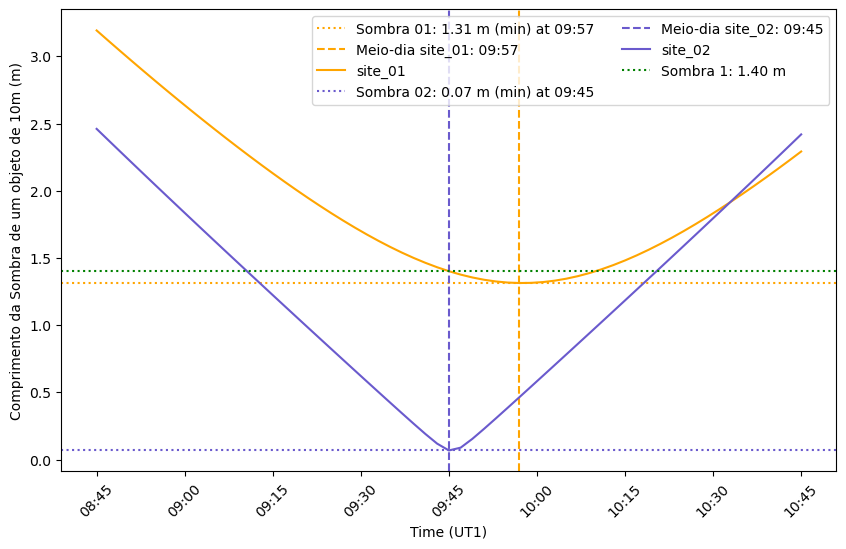

In [4]:
view_shadow_length(df)

In [5]:
from geopy.distance import geodesic, great_circle
import osmnx as ox
import numpy as np
from rich.console import Console
from rich.table import Table
h = 10
alexandria_coords = ox.geocode(alexandria)
aswan_coords = ox.geocode(aswan)
distance = geodesic(alexandria_coords, aswan_coords).km
great_circle_distance = great_circle(alexandria_coords, aswan_coords).km

noon_aswan = df["time_02"].iloc[df.reset_index()["shadow_length_02"].idxmin()]
noon_alexandria = df["time_02"].iloc[df.reset_index()["shadow_length_01"].idxmin()]

shadow_length_01 = df[df.time_02==noon_aswan]["shadow_length_01"].values[0]
shadow_length_02 = df[df.time_02==noon_aswan]["shadow_length_02"].values[0]
min_shadow_01 = df[df.time_02==noon_alexandria]["shadow_length_01"].values[0]

sol_coords_01 = df[df.time_02==noon_aswan][["alt_01", "az_01"]].values[0]
sol_coords_02 = df[df.time_02==noon_aswan][["alt_02", "az_02"]].values[0]
sol_coords_a = df[df.time_02==noon_alexandria][["alt_01", "az_01"]].values[0]

theta_alexandria = np.arctan(shadow_length_01 / h)  # Assuming object height is 10
theta_aswan = np.arctan(shadow_length_02 / h)  # Assuming object height is 10

R_terra = distance / theta_alexandria


### Reproduzindo o Experimento de Eratosthenes

In [6]:
table = Table(title="Experimento de Erathostenes")

table.add_column("Grandezas", justify="right", style="cyan", no_wrap=True)
table.add_column("Alexandria", style="yellow")
table.add_column("Aswann", justify="right", style="green")

table.add_row("meio-dia", noon_alexandria.strftime("%H:%M"), noon_aswan.strftime("%H:%M"))
table.add_row("coordenadas", f"{alexandria_coords[0]:.2f}, {alexandria_coords[1]:.2f}", f"{aswan_coords[0]:.2f}, {aswan_coords[1]:.2f}")
table.add_row("sombra", f"{shadow_length_01:.2f} m", f"{shadow_length_02:.2f} m")
table.add_row("ângulo", f"{np.degrees(theta_alexandria):.2f}°", f"{np.degrees(theta_aswan):.2f}°")
table.add_row("Sol meio-dia", f"alt: {sol_coords_a[0]:.2f}°, az: {sol_coords_a[1]:.2f}°", f"alt: {sol_coords_02[0]:.2f}°, az: {sol_coords_02[1]:.2f}°")
table.add_row("Sol meio-dia aswan", f"alt: {sol_coords_01[0]:.2f}°, az: {sol_coords_01[1]:.2f}°", f"alt: {sol_coords_02[0]:.2f}°, az: {sol_coords_02[1]:.2f}°")
d_theta = np.degrees(theta_aswan - theta_alexandria)
d_phi = np.abs((noon_alexandria - noon_aswan).total_seconds()) * 24 / 3600  # Convertendo de segundos para horas
console = Console()
console.print(table)


                        Experimento de Erathostenes                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Grandezas ┃ Alexandria               ┃                   Aswann ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           meio-dia │ 09:57                    │                    09:45 │
│        coordenadas │ 31.20, 29.90             │             24.09, 32.90 │
│             sombra │ 1.40 m                   │                   0.07 m │
│             ângulo │ 7.98°                    │                    0.39° │
│       Sol meio-dia │ alt: 82.52°, az: 179.12° │ alt: 89.61°, az: 163.38° │
│ Sol meio-dia aswan │ alt: 82.02°, az: 158.93° │ alt: 89.61°, az: 163.38° │
└────────────────────┴──────────────────────────┴──────────────────────────┘

### Aprendendo sobre Latitudes e Longitudes

A diferença de Latitude é a diferença de altura do Sol nos dois locais, medidos na mesma hora.

In [7]:
# O sinal é porque a altitude do sol é 90 menos o angulo da sombra
delta_lat = float(-(sol_coords_a - sol_coords_02)[0])
console.print(f"Delta latitude: {delta_lat:.2f}°")

Delta latitude: 7.09°

A diferença de longitude é a diferença de tempo para as passagens no meridiano, convertida em horas.
Falta apenas calcular o tempo em Alexandria.

In [8]:
# O sinal esta relacionado com a rotação da terra
delta_t = (noon_alexandria - noon_aswan).total_seconds()
# Convertendo em graus
delta_lon = float(-delta_t * 360 / (24 * 3600))  # 24 hours in seconds
console.print(f"Delta longitude: {delta_lon:.2f}°")

Delta longitude: -3.00°

Comparando com os dados geográficos temos: 

In [9]:
def format_list(lst):
    return ", ".join(f"{x:.2f}" for x in lst)

delta_coords_astro = [delta_lat, delta_lon]
delta_coords_geo = [alexandria_coords[0] - aswan_coords[0], alexandria_coords[1] - aswan_coords[1]]
console.print(f"Delta coordenadas astronômicas: {format_list(delta_coords_astro)}")
console.print(f"Delta coordenadas geográficas: {format_list(delta_coords_geo)}")

Delta coordenadas astronômicas: 7.09, -3.00

Delta coordenadas geográficas: 7.11, -3.00

## Correções ao Experimento

Precisamos considerar que: 
- ‼️O tamanho da sombra em Aswan não é zero, sua latitude não é no trópico de câncer.
- ‼️A longitude das cidades não é a mesma.

Para dois pontos na esfera, a distância entre eles é dada pela fórmula de Haversine

$$ D(x, y) = 2 \mathrm{arcsen}\left[ \sqrt{\sin^2\left(\frac{x_{lat} - y_{lat}}{2}\right) + \cos(x_{lat})\cos({y_{lat}}) \sin^2\left(\frac{x_{lon} - y_{lon}}{2}\right)} \right]
$$

A diferença de longitude é a diferença de tempo para as passagens no meridiano, convertida em horas.
Falta apenas calcular o tempo em Alexandria.

Não temos como saber as coordenadas exatas, vamos colocar a origem em Alexandra e determinar as coordenadas relativas de Aswan:

In [10]:
lat_alexandria, lon_alexandria = (0, 0)
lat_aswan, lon_aswan = (delta_lat, delta_lon)
R_terra_corrected = great_circle_distance / (2 * np.arcsin( np.sqrt( np.sin(np.radians((lat_alexandria - lat_aswan) / 2))**2 + np.cos(np.radians(lat_alexandria)) * np.cos(np.radians(lat_aswan)) * np.sin(np.radians((lon_alexandria - lon_aswan) / 2))**2)))

In [11]:
import astropy.constants as const
R_terra_earth = const.R_earth.value / 1000  # Convertendo para km

results = Table(title="Raio da Terra")

results.add_column("Grandezas", justify="right", style="cyan", no_wrap=True)
results.add_column("Valor", justify="left", style="yellow", no_wrap=True)

results.add_row("Raio da Terra (Eratóstenes)", f"{R_terra:.2f} km")
results.add_row("Correção de Lat/Lon", f"{R_terra_corrected:.2f} km")
results.add_row("Valor WSG84",  f"{R_terra_earth:.2f} km")
results.add_row("Diferença (Corrigido - Nominal)", f"{R_terra_corrected - R_terra_earth:.2f} km")
results.add_row("Diferença (Eratostenes - Nominal)", f"{R_terra - R_terra_earth:.2f} km")
results.add_row("Diferença porcentual (corrigido)", f"{((R_terra_corrected - R_terra_earth) / R_terra_earth) * 100:.2f}%")
results.add_row("Diferença porcentual (Eratostenes)", f"{((R_terra - R_terra_earth) / R_terra_earth) * 100:.2f}%")

console.print(results)

                   Raio da Terra                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃                          Grandezas ┃ Valor      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│        Raio da Terra (Eratóstenes) │ 6042.50 km │
│                Correção de Lat/Lon │ 6279.87 km │
│                        Valor WSG84 │ 6378.10 km │
│    Diferença (Corrigido - Nominal) │ -98.23 km  │
│  Diferença (Eratostenes - Nominal) │ -335.60 km │
│   Diferença porcentual (corrigido) │ -1.54%     │
│ Diferença porcentual (Eratostenes) │ -5.26%     │
└────────────────────────────────────┴────────────┘